# Regression-based Models with Trend and Seasonality

### Load required packages.

In [1]:
from pathlib import Path

import math
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools 
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from dmba import regressionSummary
import warnings

import matplotlib.pylab as plt
%matplotlib inline

no display found. Using non-interactive Agg backend


### Create templates for graph layout.

In [2]:
# Create a template for graph layout with partitions for data set. 
def Graph_Layout_Partition_Data():
    # Determine coordinates for drawing vertical lines and 
    # horizontal arrows on the chart.    
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
    xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
    xfuture = (max(valid_ts.index) + one_month, '2022')
    xtv = xtrain[1] + 0.7 * (xvalid[0] - xtrain[1])
    xvf = xvalid[1] + 1.0 * (xfuture[0] - xvalid[1])

    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2013-12', 3300), xytext=('1991', 3300), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2018-12', 3300), xytext=('2014-2', 3300), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2021-12', 3300), xytext=('2019-2', 3300), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('2001', 3330, 'Training')
    ax.text('2015-1', 3330, 'Validation')
    ax.text('2019-7', 3330, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2022')
    ax.set_ylim(1300, 3500)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')

# Create a template for graph layout with partitions for residuals. 
def Graph_Layout_Partition_Residuals():
    # Determine coordinates for drawing vertical lines and 
    # horizontal arrows on the chart.    
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
    xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
    xfuture = (max(valid_ts.index) + one_month, '2022')
    xtv = xtrain[1] + 0.7 * (xvalid[0] - xtrain[1])
    xvf = xvalid[1] + 1.0 * (xfuture[0] - xvalid[1])

    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2013-12', 600), xytext=('1991', 600), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2018-12', 600), xytext=('2014-2', 600), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2021-12', 600), xytext=('2019-2', 600), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('2001', 620, 'Training')
    ax.text('2015-1', 620, 'Validation')
    ax.text('2019-7', 620, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2022')
    ax.set_ylim(-600, 700)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')


# Create a template for graph layout with entire dataset and 12 periods 
# into future. 
def Graph_Layout_Entire_Data():
    # Determine coordinates for drawing vertical lines and horizontal 
    # arrows on the chart.
    one_month = pd.Timedelta('31 days')
    xridership = (min(ridership_ts.index), max(ridership_ts.index) - one_month)
    xfuture = (max(ridership_ts.index) + one_month, '2022')
    xvf = xridership[1] + 0.7 * (xfuture[0] - xridership[1])

    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2018-12', 3300), xytext=('1991', 3300), 
              arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2021-12', 3300), xytext=('2019-2', 3300), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('2005', 3330, 'Training')
    ax.text('2019-7', 3330, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2022')
    ax.set_ylim(1300, 3500)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')
    

# Create a template for graph layout with entire data for residuals. 
def Graph_Layout_Entire_Data_Residuals():
    # Determine coordinates for drawing vertical lines and 
    # horizontal arrows on the chart.    
    one_month = pd.Timedelta('31 days')
    xridership = (min(ridership_ts.index), max(ridership_ts.index) - one_month)
    xfuture = (max(ridership_ts.index) + one_month, '2022')
    xvf = xridership[1] + 0.7 * (xfuture[0] - xridership[1])

    ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)

    plt.annotate('', xy=('2018-12', 600), xytext=('1991', 600), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))
    plt.annotate('', xy=('2021-12', 600), xytext=('2019-2', 600), 
             arrowprops=dict(arrowstyle="<->", shrinkA=0, shrinkB=0))

    # Input text on the arrows.
    ax.text('2005', 620, 'Training')
    ax.text('2019-7', 620, 'Future')

    # Create limits and axis labels.
    ax.set_xlim('1990', '2022')
    ax.set_ylim(-600, 700)
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')

### Create measures of forecast accuracy.

In [3]:
# Create forcast accuracy measures.
def Forecast_Accuracy(actual, forecast):
    
    # ME - mean error
    me = round(np.mean(actual - forecast),3) 
    
    # RMSE - root mean square error (RMSE)
    rmse = round((np.mean((actual - forecast)**2)**.5),3)  
   
    # MAE - mean absolute error
    mae = round(np.mean(np.abs(actual - forecast)),3)   
   
    # MPE - mean percentage error,%
    mpe = round(((np.mean((actual - forecast)/actual))*100),3) 
    
    # MAPE - mean absolute percentage error, %
    mape = round(((np.mean(np.abs((actual - forecast)/actual)))*100),3) 
    
    # Ignore unnecessary future warnings on ACF1. 
    warnings.filterwarnings('ignore')
    
    # ACF1 - autocorrelation of errors at lag 1
    acf1 = round((acf(actual - forecast)[1]),3)                 
    
    return({'ME':me, 'RMSE':rmse, 'MAE':mae, 
            'MPE':mpe, 'MAPE':mape, 'ACF1':acf1})

### Create time series data set and partition data set.

In [4]:
# Create Amtrak data frame.
Amtrak_data = pd.read_csv('Amtrak_comp.csv')

# Display the first 5 records of Amtrak data set.

# Convert the date information to a datetime object as monthly data.
Amtrak_data['Date'] = pd.to_datetime(Amtrak_data.Month)

# Convert data set to time series  data set. Name is used 
# to label the data.
ridership_ts = pd.Series(Amtrak_data.Ridership.values, 
                index=Amtrak_data.Date, name='Ridership')

# Define Amtrak time series frequency as month 'MS'. 
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq = 'MS')

# Display first 5 records of Amtrak time series data.
ridership_ts.head()

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
Freq: MS, Name: Ridership, dtype: float64

In [5]:
# Create training and validation data partition for all regression
# models with trend and/or seasonality. 

# Define the numbers of months in the training and validation data sets,
# nTrain and nValid, respectively and create data partition, train_ts
# and valid_ts.
nValid = 60
nTrain = len(ridership_ts) - nValid
train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

# Create a time series dataframe with additional linear trend term (t) 
# and constant term (c) for entire data set. This will enable 
# to develop training and validation partition for all models.
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
print('Entire Data Set with Trend and Constant')
print(ridership_df)

# Develop monthly index for ridership_df.
ridership_df['Month'] = ridership_df.index.month

# Partition the training data set using ridership_df and display it. 
train_df = ridership_df[:nTrain]
print(' ')
print('Training Data Set')
print(train_df)

# Partition the validation data set using ridership_df and display it. 
valid_df = ridership_df[nTrain:]
print(' ')
print('Validation Data Set')
print(' ')
print('Validation Data Set')
print(valid_df.head())
print('                 ...')
print(valid_df.tail())


Entire Data Set with Trend and Constant
            Ridership  const  trend
Date                               
1991-01-01   1708.917    1.0    1.0
1991-02-01   1620.586    1.0    2.0
1991-03-01   1972.715    1.0    3.0
1991-04-01   1811.665    1.0    4.0
1991-05-01   1974.964    1.0    5.0
...               ...    ...    ...
2018-08-01   2848.935    1.0  332.0
2018-09-01   2522.367    1.0  333.0
2018-10-01   2807.200    1.0  334.0
2018-11-01   2873.968    1.0  335.0
2018-12-01   2668.049    1.0  336.0

[336 rows x 3 columns]
 
Training Data Set
            Ridership  const  trend  Month
Date                                      
1991-01-01   1708.917    1.0    1.0      1
1991-02-01   1620.586    1.0    2.0      2
1991-03-01   1972.715    1.0    3.0      3
1991-04-01   1811.665    1.0    4.0      4
1991-05-01   1974.964    1.0    5.0      5
...               ...    ...    ...    ...
2013-08-01   2851.979    1.0  272.0      8
2013-09-01   2440.153    1.0  273.0      9
2013-10-01   2625.

### Fit regression model with linear trend: Model 1. Forecast and plot data, and measure accuracy. 

In [6]:
# Use statsmodels' (sm) ols() function (ordinary least squares) to create 
# regression model with linear trend for training data.
train_lin = sm.ols(formula='Ridership ~ trend', data=train_df).fit()

# See summary of linear trend model ans associated parameters. 
print(' ')
print("Parameters for Linear Trend Regression")
print(train_lin.summary())

# Print fitted values from linear trend for training data.
print(' ')
print('Linear Trend/Fit for Training Data')
print(train_lin.fittedvalues)

# Apply predict() function to make forecast using linear  
# trend for validation period.  
train_lin_pred = train_lin.predict(valid_df)
print(' ')
print('Linear Forecast for Validation Data')
print(train_lin_pred.head())
print('                 ...')
print(train_lin_pred.tail())

 
Parameters for Linear Trend Regression
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     544.1
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           4.87e-67
Time:                        17:36:35   Log-Likelihood:                -1854.5
No. Observations:                 276   AIC:                             3713.
Df Residuals:                     274   BIC:                             3720.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

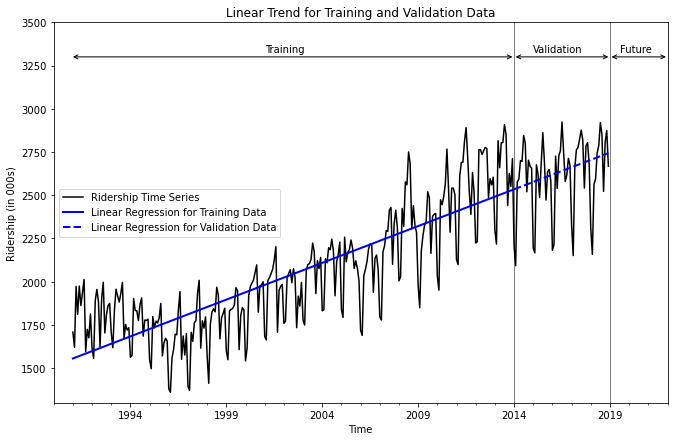

In [8]:
# Plot ts data, linear trend for training period, and forecast
# for validation period.

# Plot entire data set that combines training and validation.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(11,7))

# Plot linear trend for training and valiation sets.
train_lin.fittedvalues.plot(ax = ax, color="blue", linewidth=2)
train_lin_pred.plot(ax = ax, color="blue", style='--', linewidth=2)

# Use template of graph layout for partitions.
Graph_Layout_Partition_Data()

# Create graph legend and title.
ax.legend(['Ridership Time Series', 'Linear Regression for Training Data', 
           'Linear Regression for Validation Data'],
           loc = 'center left')
plt.title('Linear Trend for Training and Validation Data')

plt.show()

In [9]:
# Use regressionSummary() to identfiy common accuracy menasures 
# for linear trend. 
print('Linear Trend Measures')
regressionSummary(valid_ts, train_lin_pred)

Linear Trend Measures

Regression statistics

                      Mean Error (ME) : -22.3345
       Root Mean Squared Error (RMSE) : 208.7877
            Mean Absolute Error (MAE) : 159.3591
          Mean Percentage Error (MPE) : -1.5526
Mean Absolute Percentage Error (MAPE) : 6.4719


### Fit regression model with exponential trend: Model 2. Forecast and plot data, and measure accuracy. 

In [10]:
# Use statsmodels' (sm) ols() function (ordinary least squares) to create 
# regression model with exponential trend for training data.
train_expo = sm.ols(formula='np.log(Ridership) ~ trend', data=train_df).fit()

# See summary of exponential trend model ans associated parameters. 
print(' ')
print("Parameters for Exponential Trend Regression")
print(train_expo.summary())

# Print fitted values from exponential trend for training data.
# Use lambda from math package for Box-Cox transformation of log(y)function.
train_expo_fit=train_expo.fittedvalues.apply(lambda row: math.exp(row))
print(' ')
print('Exponential Trend/Fit for Training Data')
print(train_expo_fit)

# Apply predict() function to make forecast using exponential trend for 
# validation period. Use lambda from math package for Box-Cox 
# transformation of log(y)function. 
train_expo_pred = train_expo.predict(valid_df).apply(lambda row: math.exp(row))
print(' ')
print('Exponential Trend Forecast for Validation Data')
print(train_expo_pred.head())
print('                 ...')
print(train_expo_pred.tail())

 
Parameters for Exponential Trend Regression
                            OLS Regression Results                            
Dep. Variable:      np.log(Ridership)   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     520.8
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           2.57e-65
Time:                        17:37:58   Log-Likelihood:                 250.78
No. Observations:                 276   AIC:                            -497.6
Df Residuals:                     274   BIC:                            -490.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

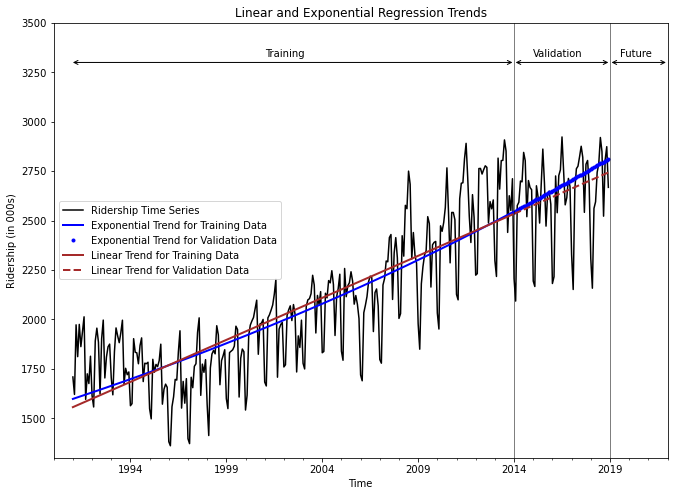

In [11]:
# Plot ts data, exponentail trend for training period, and forecast
# for validation period.

# Plot entire data set that combines training and validation.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(11,8))

# Plot exponential trend for training and valiation sets.
train_expo_fit.plot(ax = ax, color="blue", linewidth=2)
train_expo_pred.plot(ax = ax, color="blue", style='.', linewidth=2)

# Plot linear trend for training and valiation sets.
train_lin.fittedvalues.plot(ax = ax, color="brown", linewidth=2)
train_lin_pred.plot(ax = ax, color="brown", style='--', linewidth=2)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph legend and title.
ax.legend(['Ridership Time Series', 'Exponential Trend for Training Data', 
           'Exponential Trend for Validation Data', 
           'Linear Trend for Training Data',
           'Linear Trend for Validation Data'],
            loc = 'center left')
plt.title('Linear and Exponential Regression Trends')

plt.show()

In [12]:
# Use regressionSummary() to identfiy common accuracy menasures 
# for linear trend. 
print('Linear Trend Measures')
regressionSummary(valid_ts, train_lin_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for exponential trend. 
print(' ')
print('Exponential Trend Measures')
regressionSummary(valid_ts, train_expo_pred)

Linear Trend Measures

Regression statistics

                      Mean Error (ME) : -22.3345
       Root Mean Squared Error (RMSE) : 208.7877
            Mean Absolute Error (MAE) : 159.3591
          Mean Percentage Error (MPE) : -1.5526
Mean Absolute Percentage Error (MAPE) : 6.4719
 
Exponential Trend Measures

Regression statistics

                      Mean Error (ME) : -60.4854
       Root Mean Squared Error (RMSE) : 217.2731
            Mean Absolute Error (MAE) : 155.1697
          Mean Percentage Error (MPE) : -3.0069
Mean Absolute Percentage Error (MAPE) : 6.4004


### Fit regression model with quadratic (polynomial) trend: Model 3. Forecast and plot data, and measure accuracy. 

In [13]:
# Use statsmodels' (sm) ols() function (ordinary least squares) to create 
# regression model with quadratic trend for training data.
train_quad = sm.ols(formula='Ridership ~ trend + np.square(trend)', data=train_df).fit()

# See summary of quadratic trend model ans associated parameters. 
print(' ')
print("Parameters for Quadratic Trend Regression")
print(train_quad.summary())

# Print fitted values from quadratic  trend for training data.
train_quad_fit=train_quad.fittedvalues
print(' ')
print('Quadratic Trend/Fit for Training Data')
print(train_quad_fit)

# Apply predict() function to make forecast using quadratic trend for 
# validation period. 
train_quad_pred = train_quad.predict(valid_df)
print(' ')
print('Quadratic Trend Forecast for Validation Data')
print(train_quad_pred.head())
print('                 ...')
print(train_quad_pred.tail())

 
Parameters for Quadratic Trend Regression
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     402.2
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           4.18e-82
Time:                        17:39:26   Log-Likelihood:                -1816.0
No. Observations:                 276   AIC:                             3638.
Df Residuals:                     273   BIC:                             3649.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

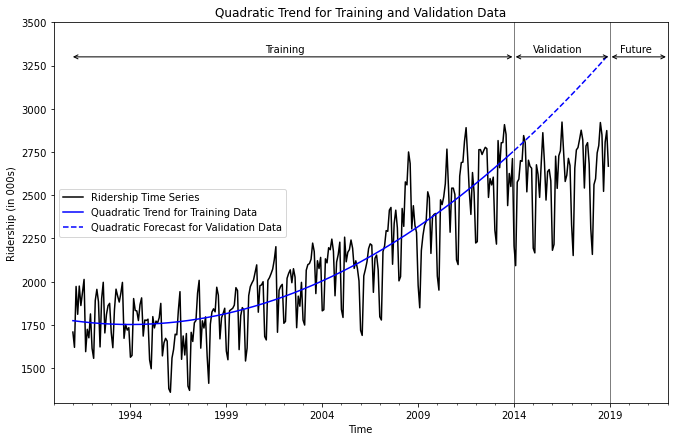

In [14]:
# Plot ts data, quadratic trend for training period, and forecast
# for validation period.

# Plot entire data set that combines training and validation.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(11,7))

# Plot quadratic trend for training and valiation sets.
train_quad_fit.plot(ax = ax, color="blue", linewidth=1.5)
train_quad_pred.plot(ax = ax, color="blue", style='--', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph legend and title.
ax.legend(['Ridership Time Series', 'Quadratic Trend for Training Data', 
           'Quadratic Forecast for Validation Data'],
            loc = 'center left')
plt.title('Quadratic Trend for Training and Validation Data')

plt.show()

In [15]:
# Use regressionSummary() to identfiy common accuracy menasures 
# for linear trend. 
print('Linear Trend Measures')
regressionSummary(valid_ts, train_lin_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for quadratic trend. 
print(' ')
print('Quadratic Trend Measures')
regressionSummary(valid_ts, train_quad_pred)

Linear Trend Measures

Regression statistics

                      Mean Error (ME) : -22.3345
       Root Mean Squared Error (RMSE) : 208.7877
            Mean Absolute Error (MAE) : 159.3591
          Mean Percentage Error (MPE) : -1.5526
Mean Absolute Percentage Error (MAPE) : 6.4719
 
Quadratic Trend Measures

Regression statistics

                      Mean Error (ME) : -408.4046
       Root Mean Squared Error (RMSE) : 470.3144
            Mean Absolute Error (MAE) : 409.6164
          Mean Percentage Error (MPE) : -16.3296
Mean Absolute Percentage Error (MAPE) : 16.3722


### Fit regression model with seasonality: Model 4. Forecast and plot data, and measure accuracy. 

In [16]:
# Use statsmodels' (sm) ols() function (ordinary least squares) to create 
# regression model with seasonlaity for training data.
train_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()

# See summary of seasonality model ans associated parameters. 
print(' ')
print("Parameters for Seasonality Regression")
print(train_season.summary())

# Print fitted values from seasonality model for training data.
train_season_fit=train_season.fittedvalues
print(' ')
print('Seasonality Fit for Training Data')
print(train_season_fit)

# Apply predict() function to make forecast using seasonality model for 
# validation period. 
train_season_pred = train_season.predict(valid_df)
print(' ')
print('Seasonality Forecast for Validation Data')
print(train_season_pred.head())
print('                 ...')
print(train_season_pred.tail())

 
Parameters for Seasonality Regression
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     5.765
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           2.39e-08
Time:                        17:40:51   Log-Likelihood:                -1975.7
No. Observations:                 276   AIC:                             3975.
Df Residuals:                     264   BIC:                             4019.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Inte

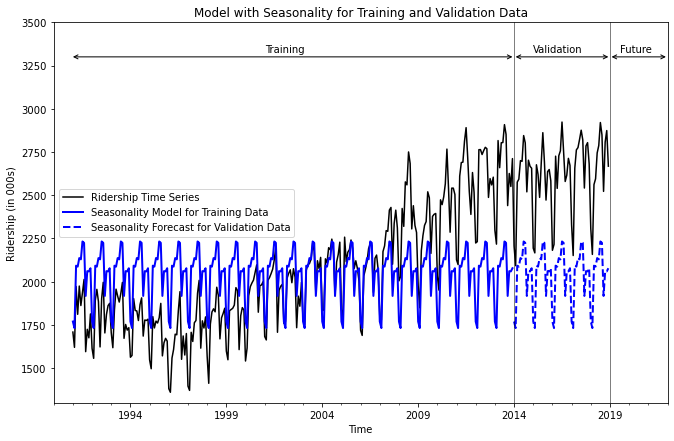

In [17]:
# Plot ts data, seasonality model for training period, and forecast
# for validation period.

# Plot entire data set that combines training and validation.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(11,7))

# Plot seasonality model for training and valiation sets.
train_season_fit.plot(ax = ax, color="blue", linewidth=2)
train_season_pred.plot(ax = ax, color="blue", style='--', linewidth=2)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph legend and title.
ax.legend(['Ridership Time Series', 'Seasonality Model for Training Data', 
           'Seasonality Forecast for Validation Data'],
           loc = 'center left')
plt.title('Model with Seasonality for Training and Validation Data')

plt.show()

In [18]:
# Residuals of regression with seasonality for training and validation 
# data partitions.  

# Identify residuals of regression with seasonality for training 
# data partition. 
season_res = train_season.resid

# Create forecast for regression with seasonality for validation 
# period.  
season_pred = train_season.predict(valid_df)

# Identify residuals of regression with seasonality for validation 
# data partition.
season_res_valid = valid_ts - season_pred

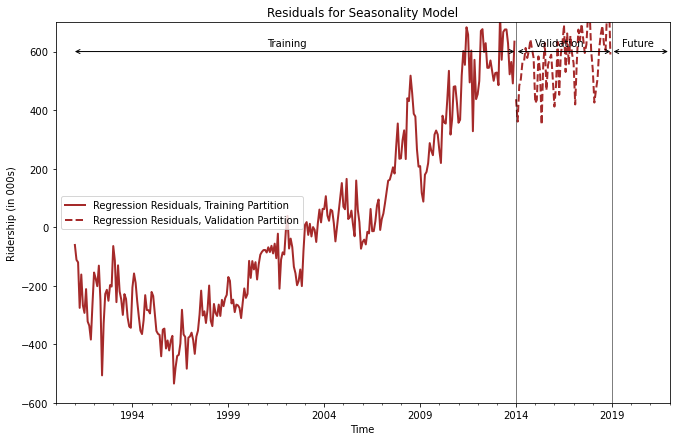

In [20]:
# Plot residuals of regression with seasonality for training
# and validation partitions.
ax = season_res.plot(color='brown', linewidth=2, figsize=(11,7))
season_res_valid.plot(ax = ax, color="brown", style='--', linewidth=2)

# Use template of graph layout for residuals with partitions.
Graph_Layout_Partition_Residuals()

# Create graph legend and title.
ax.legend(['Regression Residuals, Training Partition', 
           'Regression Residuals, Validation Partition'],
          loc = 'center left') 
        
plt.title('Residuals for Seasonality Model')

plt.show()

In [21]:
# Use regressionSummary() to identfiy common accuracy menasures 
# for linear trend. 
print('Linear Trend Measures')
regressionSummary(valid_ts, train_lin_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for quadratic trend. 
print(' ')
print('Quadratic Trend Measures')
regressionSummary(valid_ts, train_quad_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for seasonality model. 
print(' ')
print('Seasonality Measures')
regressionSummary(valid_ts, train_season_pred)

Linear Trend Measures

Regression statistics

                      Mean Error (ME) : -22.3345
       Root Mean Squared Error (RMSE) : 208.7877
            Mean Absolute Error (MAE) : 159.3591
          Mean Percentage Error (MPE) : -1.5526
Mean Absolute Percentage Error (MAPE) : 6.4719
 
Quadratic Trend Measures

Regression statistics

                      Mean Error (ME) : -408.4046
       Root Mean Squared Error (RMSE) : 470.3144
            Mean Absolute Error (MAE) : 409.6164
          Mean Percentage Error (MPE) : -16.3296
Mean Absolute Percentage Error (MAPE) : 16.3722
 
Seasonality Measures

Regression statistics

                      Mean Error (ME) : 572.9991
       Root Mean Squared Error (RMSE) : 580.9279
            Mean Absolute Error (MAE) : 572.9991
          Mean Percentage Error (MPE) : 21.8061
Mean Absolute Percentage Error (MAPE) : 21.8061


### Fit regression model with linear trend and seasonality: Model 5. Forecast and plot data, and measure accuracy. 

In [22]:
# Use statsmodels' (sm) ols() function (ordinary least squares) to create 
# regression model with linear trend and seasonality for training data.
train_lin_season = sm.ols(formula='Ridership ~ trend + C(Month)', 
                      data=train_df).fit()

# See summary of linear trend and seasonality model ans associated parameters. 
print(' ')
print("Parameters for Linear Trend and Seasonality Regression")
print(train_lin_season.summary())

# Print fitted values from linear trend and seasonality model for training data.
train_lin_season_fit=train_lin_season.fittedvalues
print(' ')
print('Linear Trend and Seasonality Fit for Training Data')
print(train_lin_season_fit)

# Apply predict() function to make forecast using linear trend and 
# seasonality model for validation period. 
train_lin_season_pred = train_lin_season.predict(valid_df)
print(' ')
print('LinearTrend and Seasonality Forecast for Validation Data')
print(train_lin_season_pred.head())
print('                 ...')
print(train_lin_season_pred.tail())

 
Parameters for Linear Trend and Seasonality Regression
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     120.5
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           2.02e-99
Time:                        17:48:34   Log-Likelihood:                -1747.1
No. Observations:                 276   AIC:                             3520.
Df Residuals:                     263   BIC:                             3567.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

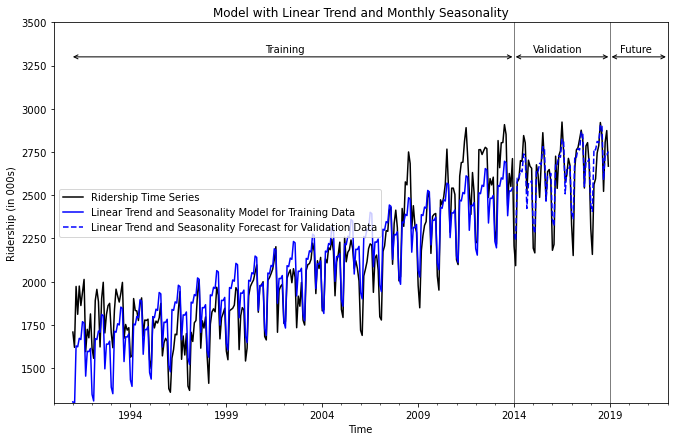

In [25]:
# Plot ts data,linear trend and seasonality model for training period, and forecast
# for validation period.

# Plot entire data set that combines training and validation.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(11,7))

# Plot seasonality model for training and valiation sets.
train_lin_season_fit.plot(ax = ax, color="blue", linewidth=1.5)
train_lin_season_pred.plot(ax = ax, color="blue", style='--', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph legend and title.
ax.legend(['Ridership Time Series', 'Linear Trend and Seasonality Model for Training Data', 
           'Linear Trend and Seasonality Forecast for Validation Data'],
           loc = 'center left')
plt.title('Model with Linear Trend and Monthly Seasonality')

plt.show()

In [30]:
# Residuals of regression with linear trend and seasonality for 
# training and validation data partitions.  

# Identify residuals of regression with trend and seasonality for 
# training data partition. 
lin_season_res = train_lin_season.resid

# Create forecast for regression with trend and seasonality 
# for validation period.  
lin_season_pred = train_lin_season.predict(valid_df)

# Identify residuals of regression with trend and seasonality 
# for validation data partition.
lin_season_res_valid = valid_ts - lin_season_pred

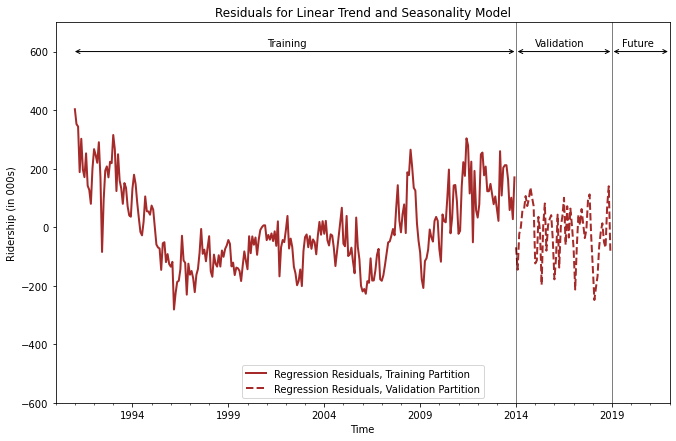

In [35]:
# Plot residuals of regression with linear trend and seasonality for
# training and validation partitions.
ax = lin_season_res.plot(color='brown', linewidth=2, figsize=(11,7))
lin_season_res_valid.plot(ax = ax, color="brown", style='--', linewidth=2)

# Use template of graph layout for residuals with partitions.
Graph_Layout_Partition_Residuals()

# Create graph legend and title.
ax.legend(['Regression Residuals, Training Partition', 
           'Regression Residuals, Validation Partition'],
           loc = 'lower center') 
        
plt.title('Residuals for Linear Trend and Seasonality Model')

plt.show()

### Fit regression model with quadratic trend and seasonality: Model 6. Forecast and plot data, and measure accuracy. 

In [38]:
# Use statsmodels' (sm) ols() function (ordinary least squares) to create 
# regression model with quadratic trend and seasonality for training data.
train_quad_season = sm.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', 
                      data=train_df).fit()

# See summary of quadratic trend and seasonality model ans associated parameters. 
print(' ')
print("Parameters for Quadratic Trend and Seasonality Regression")
print(train_quad_season.summary())

# Print fitted values from quadratic trend and seasonality model for training data.
train_quad_season_fit=train_quad_season.fittedvalues
print(' ')
print('Quadratic Trend and Seasonality Fit for Training Data')
print(train_quad_season_fit)

# Apply predict() function to make forecast using quadratic trend and 
# seasonality model for validation period. 
train_quad_season_pred = train_quad_season.predict(valid_df)
print(' ')
print('Quadratic Trend and Seasonality Forecast for Validation Data')
print(train_quad_season_pred.head())
print('                 ...')
print(train_quad_season_pred.tail())

 
Parameters for Quadratic Trend and Seasonality Regression
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     259.6
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          2.54e-141
Time:                        18:10:12   Log-Likelihood:                -1642.4
No. Observations:                 276   AIC:                             3313.
Df Residuals:                     262   BIC:                             3363.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

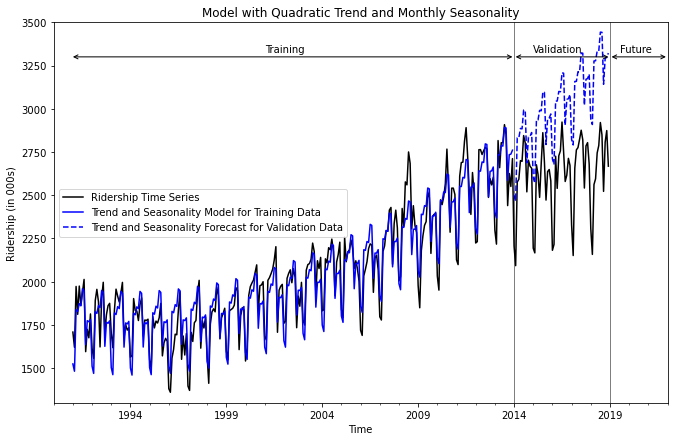

In [39]:
# Plot ts data, quadratic trend and seasonality model for training period, and forecast
# for validation period.

# Plot entire data set that combines training and validation.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(11,7))

# Plot seasonality model for training and valiation sets.
train_quad_season_fit.plot(ax = ax, color="blue", linewidth=1.5)
train_quad_season_pred.plot(ax = ax, color="blue", style='--', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Partition_Data()

# Create graph legend and title.
ax.legend(['Ridership Time Series', 'Trend and Seasonality Model for Training Data', 
           'Trend and Seasonality Forecast for Validation Data'],
            loc = 'center left')
plt.title('Model with Quadratic Trend and Monthly Seasonality')

plt.show()

In [40]:
# Residuals of regression with  quadratic trend and seasonality 
# for training and validation data partitions.  

# Identify residuals of regression with trend and seasonality for 
# training data partition. 
quad_season_res = train_quad_season.resid

# Create forecast for regression with trend and seasonality 
# for validation period.  
quad_season_pred = train_quad_season.predict(valid_df)

# Identify residuals of regression with trend and seasonality 
# for validation data partition.
quad_season_res_valid = valid_ts - quad_season_pred

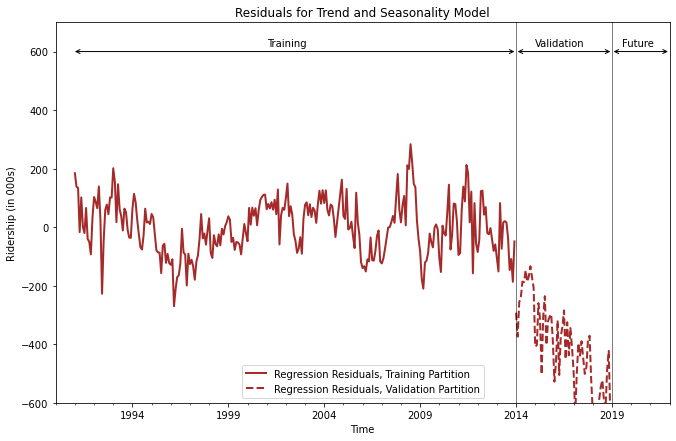

In [41]:
# Plot residuals of regression with quadratic trend and seasonality for
# training and validation partitions.
ax = quad_season_res.plot(color='brown', linewidth=2, figsize=(11,7))
quad_season_res_valid.plot(ax = ax, color="brown", style='--', linewidth=2)

# Use template of graph layout for residuals with partitions.
Graph_Layout_Partition_Residuals()

# Create graph legend and title.
ax.legend(['Regression Residuals, Training Partition', 
           'Regression Residuals, Validation Partition'],
            loc = 'lower center') 
        
plt.title('Residuals for Trend and Seasonality Model')

plt.show()

In [42]:
# Use regressionSummary() to identfiy common accuracy menasures 
# for linear trend. 
print('Linear Trend Measures')
regressionSummary(valid_ts, train_lin_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for quadratic trend. 
print(' ')
print('Quadratic Trend Measures')
regressionSummary(valid_ts, train_quad_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for seasonality model. 
print(' ')
print('Seasonality Measures')
regressionSummary(valid_ts, train_season_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for linear trend and seasonality model. 
print(' ')
print('Linear Trend and Seasonality Measures')
regressionSummary(valid_ts, train_lin_season_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for quadratic trend and seasonality model. 
print(' ')
print('Quadratic Trend and Seasonality Measures')
regressionSummary(valid_ts, train_quad_season_pred)

Linear Trend Measures

Regression statistics

                      Mean Error (ME) : -22.3345
       Root Mean Squared Error (RMSE) : 208.7877
            Mean Absolute Error (MAE) : 159.3591
          Mean Percentage Error (MPE) : -1.5526
Mean Absolute Percentage Error (MAPE) : 6.4719
 
Quadratic Trend Measures

Regression statistics

                      Mean Error (ME) : -408.4046
       Root Mean Squared Error (RMSE) : 470.3144
            Mean Absolute Error (MAE) : 409.6164
          Mean Percentage Error (MPE) : -16.3296
Mean Absolute Percentage Error (MAPE) : 16.3722
 
Seasonality Trend Measures

Regression statistics

                      Mean Error (ME) : 572.9991
       Root Mean Squared Error (RMSE) : 580.9279
            Mean Absolute Error (MAE) : 572.9991
          Mean Percentage Error (MPE) : 21.8061
Mean Absolute Percentage Error (MAPE) : 21.8061
 
Linear Trend and Seasonality Measures

Regression statistics

                      Mean Error (ME) : -17.2243
       

### Use accuracy measures from Forecast_Accuracy() function to compare different regression methods.

In [43]:
# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common 
# accuracy measures for linear trend.
print("Accuracy Measures for Linear Trend")
print(Forecast_Accuracy(valid_ts, train_lin_pred))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy measures
# for quadratic trend.
print(' ')
print("Accuracy Measures for Quadratic Trend")
print(Forecast_Accuracy(valid_ts, train_quad_pred))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy measures
# for seasonality model.
print(' ')
print("Accuracy Measures for Seasonality")
print(Forecast_Accuracy(valid_ts, train_season_pred))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy measures
# for quadratic trend with seasonality.
print(' ')
print("Accuracy Measures for Linear Trend and Seasonality")
print(Forecast_Accuracy(valid_ts, train_lin_season_pred))

# Use Forecast_Accuracy(actual, forecast) function 
# defined in this file to identfiy common accuracy measures
# for quadratic trend with seasonality.
print(' ')
print("Accuracy Measures for Quadratic Trend and Seasonality")
print(Forecast_Accuracy(valid_ts, train_quad_season_pred))

Accuracy Measures for Linear Trend
{'ME': -22.335, 'RMSE': 208.788, 'MAE': 159.359, 'MPE': -1.553, 'MAPE': 6.472, 'ACF1': 0.431}
 
Accuracy Measures for Quadratic Trend
{'ME': -408.405, 'RMSE': 470.314, 'MAE': 409.616, 'MPE': -16.33, 'MAPE': 16.372, 'ACF1': 0.553}
 
Accuracy Measures for Trend with Seasonality
{'ME': 572.999, 'RMSE': 580.928, 'MAE': 572.999, 'MPE': 21.806, 'MAPE': 21.806, 'ACF1': 0.463}
 
Accuracy Measures for Linear Trend and Seasonality
{'ME': -17.224, 'RMSE': 95.541, 'MAE': 76.238, 'MPE': -0.892, 'MAPE': 3.04, 'ACF1': 0.42}
 
Accuracy Measures for Quadratic Trend and Seasonality
{'ME': -403.996, 'RMSE': 430.701, 'MAE': 403.996, 'MPE': -15.695, 'MAPE': 15.695, 'ACF1': 0.744}


### Fit regression model with linear trend and seasonality for entire data set.  Forecast and plot data, and measure accuracy. 

In [68]:
# Use statsmodels' (sm) ols() function (ordinary least squares) to create 
# regression model with linear trend and seasonality model for entire
# data set. 
lin_season = sm.ols(formula='Ridership ~ trend + C(Month)', 
                      data=ridership_df).fit()

# See summary of linear trend and seasonality model ans associated parameters. 
print(' ')
print("Parameters for Linear Trend and Seasonality Regression")
print(lin_season.summary())

# Print fitted values from linear trend and seasonality model for 
# entire data set.
lin_season_fit = lin_season.fittedvalues
print(' ')
print('Linear Trend and Seasonality Fit for Entire Data Set')
print(lin_season_fit)


 
Parameters for Linear Trend and Seasonality Regression
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     224.6
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          1.05e-148
Time:                        19:17:36   Log-Likelihood:                -2109.0
No. Observations:                 336   AIC:                             4244.
Df Residuals:                     323   BIC:                             4294.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [69]:
# Create dataframe and time series with 12 future periods, and apply them
# to forecast with linear trend and seasonality.

# Create a dataframe with 12 periods into the future and add 
# regression linear trend and seasonality forecast for these 
# 12 periods according to the ridership_ts.

Month = pd.Series(['2019-01-01','2019-02-01','2019-03-01',
                   '2019-04-01','2019-05-01','2019-06-01',
                   '2019-07-01','2019-08-01','2019-09-01',
                   '2019-10-01','2019-11-01','2019-12-01'], 
                      name='Month')     
trend = pd.Series([337, 338, 339, 340, 341, 342, 343, 344, 
                   345, 346, 347, 348], name='trend')
idx = [337, 338, 339, 340, 341, 342, 343, 344, 
                 345, 346, 347, 348]
Month.index = idx
trend.index = idx
future12 = pd.concat([Month, trend], axis=1)
future12.index = idx
Month = pd.to_datetime(Month)

# Convert the date information to a datetime object 
# as monthly data.
future12['Date'] = pd.to_datetime(future12.Month, 
                      format='%Y/%m/%d')

# Convert dataframe column to time series (name is used 
# to label the data).
future12_ts = pd.Series(future12.trend.values, 
                 index=future12.Date, name='trend')

future12_df=tsatools.add_trend(future12_ts, trend='c')
future12_df['Month'] = future12_df.index.month

# Apply predict() function to make forecast using linear trend and 
# seasonality model for 12 future periods. 
lin_season_pred = lin_season.predict(future12_df)
print(' ')
print('Linear Trend and Seasonality Forecast for Future 12 Periods')
print(lin_season_pred)


 
Linear Trend and Seasonality Forecast for Future 12 Periods
Date
2019-01-01    2456.301249
2019-02-01    2409.923142
2019-03-01    2792.287428
2019-04-01    2784.801499
2019-05-01    2836.938499
2019-06-01    2841.992856
2019-07-01    2951.144356
2019-08-01    2926.603142
2019-09-01    2628.541035
2019-10-01    2779.037392
2019-11-01    2783.324999
2019-12-01    2782.435678
dtype: float64


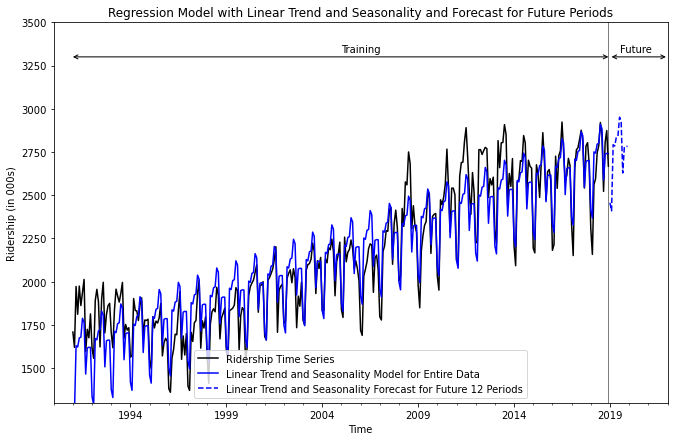

In [70]:
# Plot ts data, linear trend and seasonality model for entire data set
# (training period), and forecast for 12 future periods (months).

# Plot entire data set.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(11,7))

# Plot linear trend and seasonality model for training and valiation sets.
lin_season_fit.plot(ax = ax, color="blue", linewidth=1.5)
lin_season_pred.plot(ax = ax, color="blue", style='--', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Entire_Data()

# Create graph legend and title.
ax.legend(['Ridership Time Series', 
           'Linear Trend and Seasonality Model for Entire Data', 
           'Linear Trend and Seasonality Forecast for Future 12 Periods'],
           loc ='lower center')
plt.title('Regression Model with Linear Trend and Seasonality and Forecast for Future Periods')

plt.show()

In [72]:
# Residuals of regression with linear trend and seasonality 
# for entire data set. 
# Identify residuals of regression with linear trend and seasonality 
# for training data partition. 
tot_lin_season_res = lin_season.resid

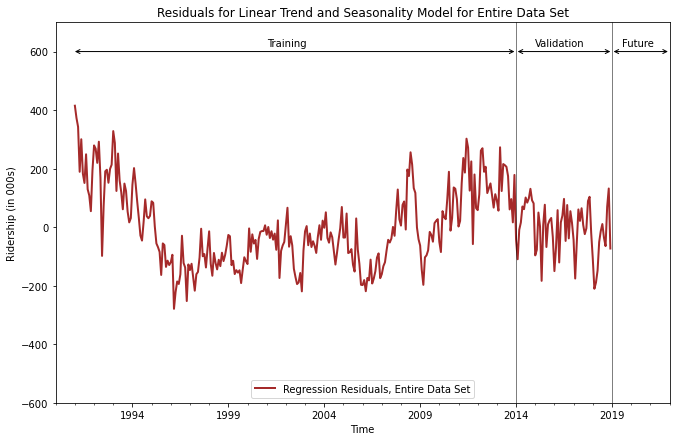

In [71]:
# Plot residuals of regression with linear trend and seasonality for
# entire data set.
ax = tot_lin_season_res.plot(color='brown', linewidth=2, figsize=(11,7))
# trend_season_res_valid.plot(ax = ax, color="brown", style='--', linewidth=2)

# Use template of graph layout for residuals with partitions.
Graph_Layout_Partition_Residuals()

# Create graph legend and title.
ax.legend(['Regression Residuals, Entire Data Set' 
          ], loc = 'lower center') 
        
plt.title('Residuals for Linear Trend and Seasonality Model for Entire Data Set')

plt.show()

### Fit regression model with quadratic trend and seasonality for entire data set.  Forecast and plot data, and measure accuracy. 

In [73]:
# Use statsmodels' (sm) ols() function (ordinary least squares) to create 
# regression model with quadratic trend and seasonality model for entire
# data set. 
quad_season = sm.ols(formula='Ridership ~ trend + np.square(trend) + C(Month)', 
                      data=ridership_df).fit()

# See summary of quadratic trend and seasonality model ans associated parameters. 
print(' ')
print("Parameters for Quadratic Trend and Seasonality Regression")
print(quad_season.summary())

# Print fitted values from quadratic trend and seasonality model for 
# entire data set.
quad_season_fit = quad_season.fittedvalues
print(' ')
print('Quadratic Trend and Seasonality Fit for Entire Data Set')
print(quad_season_fit)


 
Parameters for Quadratic Trend and Seasonality Regression
                            OLS Regression Results                            
Dep. Variable:              Ridership   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     247.2
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          9.31e-159
Time:                        19:20:18   Log-Likelihood:                -2081.9
No. Observations:                 336   AIC:                             4192.
Df Residuals:                     322   BIC:                             4245.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [74]:
# Create dataframe and time series with 12 future periods, and apply them
# to forecast with quadratic trend and seasonality.

# Create a dataframe with 12 periods into the future and add 
# regression quadratic trend and seasonality forecast for these 
# 12 periods according to the ridership_ts.

Month = pd.Series(['2019-01-01','2019-02-01','2019-03-01',
                   '2019-04-01','2019-05-01','2019-06-01',
                   '2019-07-01','2019-08-01','2019-09-01',
                   '2019-10-01','2019-11-01','2019-12-01'], 
                      name='Month')     
trend = pd.Series([337, 338, 339, 340, 341, 342, 343, 344, 
                   345, 346, 347, 348], name='trend')
idx = [337, 338, 339, 340, 341, 342, 343, 344, 
                 345, 346, 347, 348]
Month.index = idx
trend.index = idx
future12 = pd.concat([Month, trend], axis=1)
future12.index = idx
Month = pd.to_datetime(Month)

# Convert the date information to a datetime object 
# as monthly data.
future12['Date'] = pd.to_datetime(future12.Month, 
                      format='%Y/%m/%d')

# Convert dataframe column to time series (name is used 
# to label the data).
future12_ts = pd.Series(future12.trend.values, 
                 index=future12.Date, name='trend')

future12_df=tsatools.add_trend(future12_ts, trend='c')
future12_df['Month'] = future12_df.index.month

# Apply predict() function to make forecast using quadratic trend and 
# seasonality model for 12 future periods. 
quad_season_pred = quad_season.predict(future12_df)
print(' ')
print('Quadratic Trend and Seasonality Forecast for Future 12 Periods')
print(quad_season_pred)

 
Quadratic Trend and Seasonality Forecast for Future 12 Periods
Date
2019-01-01    2568.295936
2019-02-01    2523.972777
2019-03-01    2908.392011
2019-04-01    2902.961031
2019-05-01    2957.152980
2019-06-01    2964.262285
2019-07-01    3075.468733
2019-08-01    3052.982468
2019-09-01    2756.975309
2019-10-01    2909.526614
2019-11-01    2915.869170
2019-12-01    2917.034797
dtype: float64


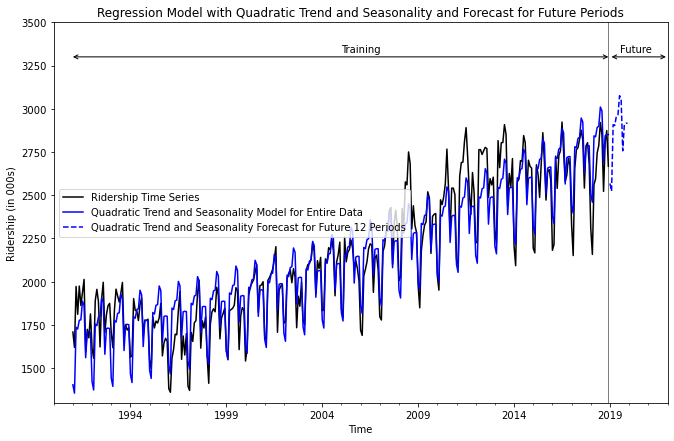

In [75]:
# Plot ts data, quadratic trend and seasonality model for entire data set
# (training period), and forecast for 12 future periods (months).

# Plot entire data set.
ax = ridership_ts.plot(color='black', linewidth=1.5, figsize=(11,7))

# Plot quadratic trend and seasonality model for training and valiation sets.
quad_season_fit.plot(ax = ax, color="blue", linewidth=1.5)
quad_season_pred.plot(ax = ax, color="blue", style='--', linewidth=1.5)

# Use template of graph layout for partitions. 
Graph_Layout_Entire_Data()

# Create graph legend and title.
ax.legend(['Ridership Time Series', 
           'Quadratic Trend and Seasonality Model for Entire Data', 
           'Quadratic Trend and Seasonality Forecast for Future 12 Periods'],
           loc ='center left')
plt.title('Regression Model with Quadratic Trend and Seasonality and Forecast for Future Periods')

plt.show()

In [77]:
# Residuals of regression with quadratic trend and seasonality 
# for entire data set. 

# Identify residuals of regression with quadratic trend and seasonality 
# for entire data set. 
tot_quad_season_res = quad_season.resid

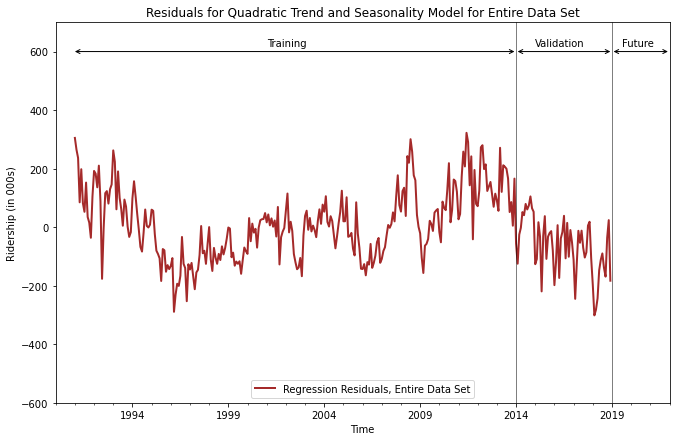

In [78]:
# Plot residuals of regression with quadratic trend and seasonality for
# entire data set.
ax = tot_quad_season_res.plot(color='brown', linewidth=2, figsize=(11,7))

# Use template of graph layout for residuals with partitions.
Graph_Layout_Partition_Residuals()

# Create graph legend and title.
ax.legend(['Regression Residuals, Entire Data Set' 
          ], loc = 'lower center') 
        
plt.title('Residuals for Quadratic Trend and Seasonality Model for Entire Data Set')

plt.show()

### Compare accuracy measures of regression forecast with quadratic trend and seasonality for the entire data set with accuracy measures of naive forecast and seasonal naive forecast for entire data set. 

In [79]:
# Generate naive and seasonal naive forecasts for entire data set 
# to compare models for entire data set.

# Take the previous value of ridership_ts[:-1] and use it as naive 
# forecast for entire data.
ridership_naive_pred = pd.Series(ridership_ts[:-1].values, 
                        index=ridership_ts[1:].index)
print('Naive Forecast for Entire Data Set')
print(ridership_naive_pred)

# Generate seasonal naive forecast for entire data set. 
# Take 12 previous periods of ridership_ts[:-12] and use it as seasonal naive 
# forecast for entire data.
ridership_snaive_pred = pd.Series(ridership_ts[:-12].values, 
                        index=ridership_ts[12:].index)
print(" ")
print('Seasonal Naive Forecast for Entire Data Set')
print(ridership_snaive_pred)

Naive Forecast for Entire Data Set
Date
1991-02-01    1708.917
1991-03-01    1620.586
1991-04-01    1972.715
1991-05-01    1811.665
1991-06-01    1974.964
                ...   
2018-08-01    2920.412
2018-09-01    2848.935
2018-10-01    2522.367
2018-11-01    2807.200
2018-12-01    2873.968
Freq: MS, Length: 335, dtype: float64
 
Seasonal Naive Forecast for Entire Data Set
Date
1992-01-01    1708.917
1992-02-01    1620.586
1992-03-01    1972.715
1992-04-01    1811.665
1992-05-01    1974.964
                ...   
2018-08-01    2819.838
2018-09-01    2541.622
2018-10-01    2785.149
2018-11-01    2804.107
2018-12-01    2680.541
Freq: MS, Length: 324, dtype: float64


In [80]:
# Use regressionSummary() to identfiy common accuracy menasures 
# for linear trend and seasonality model for entire data set.
print('Accuracy Measures for Linear Trend and Seasonality Model')
regressionSummary(ridership_ts, lin_season_fit)

# Use regressionSummary() to identfiy common accuracy menasures 
# for quadratic trend and seasonality model for entire data set.
print(' ')
print('Accuracy Measures for Quadratic Trend and Seasonality Model')
regressionSummary(ridership_ts, quad_season_fit)

# Use regressionSummary() to identfiy common accuracy menasures 
# for naive forecast in entire data set.
print(' ')
print("       Accuracy Measures for Naive Forecast")
regressionSummary(ridership_ts[1:], ridership_naive_pred)

# Use regressionSummary() to identfiy common accuracy menasures 
# for seasonal naive forecast for entire data set.
print("  ")
print("       Accuracy Measures for Seasonal Naive Forecast")
regressionSummary(ridership_ts[12:], ridership_snaive_pred)


Accuracy Measures for Linear Trend and Seasonality Model

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 128.7445
            Mean Absolute Error (MAE) : 103.7330
          Mean Percentage Error (MPE) : -0.3298
Mean Absolute Percentage Error (MAPE) : 5.1028
Accuracy Measures for Quadratic Trend and Seasonality Model

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 118.7696
            Mean Absolute Error (MAE) : 93.8801
          Mean Percentage Error (MPE) : -0.3046
Mean Absolute Percentage Error (MAPE) : 4.5096
 
       Accuracy Measures for Naive Forecast

Regression statistics

                      Mean Error (ME) : 2.8631
       Root Mean Squared Error (RMSE) : 191.6278
            Mean Absolute Error (MAE) : 140.0370
          Mean Percentage Error (MPE) : -0.2939
Mean Absolute Percentage Error (MAPE) : 6.7387
  
       Accuracy Measures for Seasonal Nai